<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/pytorch/Word2vec_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2vec

# import

In [0]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

# Ginza

In [2]:
!pip install ginza

     |████████████████████████████████| 54.9MB 56kB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
     |████████████████████████████████| 44.8MB 66kB/s 
     |████████████████████████████████| 481kB 43.9MB/s 
  Created wheel for ginza: filename=ginza-3.1.2-cp36-none-any.whl size=17311 sha256=6438676eff8fc9e514c0dd6e2ce9fb717766065b25b5574e8f32f5751a88e4c0
  Stored in directory: /root/.cache/pip/wheels/70/8d/57/f089078acc0dbaebffc08c178e9f20924fa794c114ad36f7f7
  Created wheel for ja-ginza: filename=ja_ginza-3.1.0-cp36-none-any.whl size=54963619 sha256=461f5a5f07d477212ecae03435955364ea78caee859ddf6663042e43d44f90b1
  Stored in directory: /root/.cache/pip/wheels/f2/8a/07/1837eeb5c5648fa8d266102b78a894e495234585ac3f024cf1
  Created wheel for SudachiPy: filename=SudachiPy-0.4.8-cp36-cp36m-linux_x86_64.whl size=870871 sha256=8c26b1aed0d152ac71bc9f28aeaf8fb786ed88377b1791d87f8bc41972e9db5e
  Stored in directory: /root/.cache/pip/wheels/96/01/f5/7fd64fc5305acb528a4f8a04c8b2c0641b

In [0]:
import pkg_resources, imp
imp.reload(pkg_resources)

import spacy
nlp = spacy.load('ja_ginza')

# Get corpus

In [0]:
def get_corpus(fname):
    corpus = []

    with open(fname, 'r') as f:
        for line in f.readlines():
            line = line.rstrip()
            _corpus = []
            for sent in nlp(line).sents:
                for token in sent:
                    _corpus.append(token.orth_)

            corpus = list(set(corpus) | set(_corpus))
    corpus.sort()
    return corpus

In [0]:
# sample
corpus = get_corpus('/content/drive/My Drive/Colab Notebooks/datasets/sandwitchman/sandwitchman_hanayome_original.txt')
corpus = ['<UNKNOWN>'] + corpus

In [0]:
corpus = []
for fpath in glob('/content/drive/My Drive/Colab Notebooks/datasets/sandwitchman/*_original.txt'):
    _corpus = get_corpus(fpath)
    corpus = list(set(corpus) | set(_corpus))

corpus.sort()

corpus = ['<UNKNOWN>'] + corpus

In [7]:
# show sample
corpus[:20]

['<UNKNOWN>',
 '!',
 '(',
 ')',
 '.co.jp',
 '1',
 '10',
 '100',
 '10万',
 '110',
 '12',
 '146',
 '2',
 '20',
 '200',
 '2007',
 '2008',
 '2009',
 '2010',
 '211']

In [8]:
# corpus len
len(corpus)

2151

# Get data

In [0]:
def read_data(fname, corpus):
    Xs = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            line = line.rstrip()
            _Xs = [corpus.index('<SOS>')]
            for sent in nlp(line).sents:
                for token in sent:
                    w = token.orth_

                    if w in corpus:
                        ind = corpus.index(w)
                    else:
                        ind = corpus.index('<UNKNOWN>')
                    _Xs.append(ind)
            _Xs.append(corpus.index('<EOS>'))
            Xs.append(_Xs)

    return np.array(Xs)

In [0]:
def read_data(fname, corpus):
    Xs = []
    with open(fname, 'r') as f:
        data = f.read().rstrip()

    Xs = [corpus.index(token.orth_) if token.orth_ in corpus else corpus.index('<UNKNOWN>') for sent in nlp(data).sents for token in sent]

    return np.array(Xs)

In [0]:
# read_data('/content/drive/My Drive/Colab Notebooks/datasets/sandwitchman/sandwitchman_hanayome_original.txt', corpus)

In [0]:
def get_data(data, w2v_c=None):
    Xs = []
    ts = []

    w2v_x_len = 2 * w2v_c + 1

    for i in range(0, len(data) - w2v_x_len):
        Xs.append(data[i + w2v_c])
        ts.append(data[i : i + w2v_x_len])

    return Xs, ts


In [0]:
# get training data
data_Xs = []
data_ts = []

W2V_C = 3  # word2vec window size satisfying C >= 1
W2V_X_LEN = 2 * W2V_C + 1  # training label length

for fpath in glob('/content/drive/My Drive/Colab Notebooks/datasets/sandwitchman/*_original.txt'):
    data = read_data(fpath, corpus)
    _data_Xs, _data_ts = get_data(data, w2v_c=W2V_C)
    data_Xs += _data_Xs
    data_ts += _data_ts

data_Xs = np.array(data_Xs)
data_ts = np.array(data_ts)

In [14]:
# show sample
data_Xs[:3]

array([ 454,   58, 2067])

In [15]:
# data shape
data_Xs.shape, data_ts.shape

((16513,), (16513, 7))

# Model

In [0]:
class Word2Vec(torch.nn.Module):
    def __init__(self, input_dim, dim=512, w2v_c=2):
        super(Word2Vec, self).__init__()

        self.w2v_c = w2v_c

        #self.embed = torch.nn.Linear(input_dim, dim)
        self.embed = torch.nn.Sequential(
            torch.nn.Embedding(input_dim, dim),
            torch.nn.ReLU(),
            torch.nn.Linear(dim, dim),
            torch.nn.ReLU(),
            torch.nn.Linear(dim, dim),
        )
        self.outs = []
        for _ in range(w2v_c * 2):
            self.outs.append(torch.nn.Linear(dim, input_dim))
        self.outs = torch.nn.ModuleList(self.outs)
        #self.out = torch.nn.Linear(dim, input_dim)

    def forward(self, input):
        embed = self.embed(input)

        xs = []
        for i in range(self.w2v_c * 2):
            x = self.outs[i](embed)
            #x = F.softmax(x, dim=1)
            xs.append(x)
        #x = self.out(embed)
        #x = F.softmax(x, dim=1)
        return xs

    def get_vec(self, input):
        return self.embed(input)

In [0]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
DEVICE

'cuda'

# Utility

In [0]:
class Minibatch_Generator():
    def __init__(self, data_size, batch_size, shuffle=True):
        self.data_size = data_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mbi = 0 # index for iteration
        self.inds = np.arange(data_size)
        np.random.shuffle(self.inds)

    def __call__(self):
        if self.mbi + self.batch_size > self.data_size:
            inds = self.inds[self.mbi:]
            if self.shuffle:
                np.random.shuffle(self.inds)
            inds = np.hstack((inds, self.inds[ : (self.batch_size - (self.data_size - self.mbi))]))
            self.mbi = self.batch_size - (self.data_size - self.mbi)
        else:
            inds = self.inds[self.mbi : self.mbi + self.batch_size]
            self.mbi += self.batch_size
        return inds

# train

In [0]:
# tensor
data_Xs = torch.tensor(data_Xs, dtype=torch.long).to(DEVICE)
data_ts = torch.tensor(data_ts, dtype=torch.long).to(DEVICE)

In [21]:
# train
def train():
    # model
    model = Word2Vec(len(corpus), dim=128, w2v_c=W2V_C).to(DEVICE)
    model.train()

    # minibatch index
    Minibatch_size = 64
    mb_gen = Minibatch_Generator(len(corpus), batch_size=Minibatch_size)

    # loss function
    #loss_fn = torch.nn.NLLLoss()
    loss_func = torch.nn.CrossEntropyLoss()
    
    # each learning rate and iteration

    # optimizer
    opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    
        
    # each iteration
    for ite in range(100_000):
        # get minibatch
        mb_inds = mb_gen()
        Xs = data_Xs[mb_inds]
        ts = data_ts[mb_inds]

        opt.zero_grad()

        ys = model(Xs) # feed forward

        loss = 0
        accuracy = 0

        for i in range(W2V_C):
            loss += loss_func(ys[i], ts[:, i])
            preds = ys[i].argmax(dim=1, keepdim=True).reshape(-1)
            accuracy += (preds == ts[:, i]).sum() / float(Minibatch_size)

            loss += loss_func(ys[W2V_X_LEN - i - 2], ts[:, W2V_X_LEN - i - 1])
            preds = ys[W2V_X_LEN - i - 2].argmax(dim=1, keepdim=True).reshape(-1)
            accuracy += (preds == ts[:, W2V_X_LEN - i - 1]).sum() / float(Minibatch_size)

        # loss backward
        loss.backward()

        # update weight
        opt.step()
        
        # get loss
        loss = loss.item() / W2V_X_LEN
        accuracy = accuracy.item() / W2V_X_LEN

        print('\riter:{} , L:{:.4f}, A:{:.4f}'.format(ite+1, loss, accuracy), end='')

        if (ite + 1) % 1000 == 0:
            print()

    torch.save(model.state_dict(), 'word2vec.pt')

train()

iter:1000 , L:4.1437, A:0.1094
iter:2000 , L:3.9257, A:0.1049
iter:3000 , L:3.4315, A:0.1741
iter:4000 , L:3.1370, A:0.1987
iter:5000 , L:3.0680, A:0.1652
iter:6000 , L:2.5537, A:0.1942
iter:7000 , L:2.5538, A:0.1786
iter:8000 , L:2.1660, A:0.2321
iter:9000 , L:2.1832, A:0.2478
iter:10000 , L:2.2630, A:0.2679
iter:11000 , L:2.2149, A:0.2254
iter:12000 , L:1.8999, A:0.2812
iter:13000 , L:1.7796, A:0.2991
iter:14000 , L:2.0436, A:0.2924
iter:15000 , L:2.0649, A:0.2321
iter:16000 , L:1.6473, A:0.3750
iter:17000 , L:1.9071, A:0.2835
iter:18000 , L:2.0826, A:0.2612
iter:19000 , L:1.9977, A:0.2701
iter:20000 , L:1.8735, A:0.3013
iter:21000 , L:1.9757, A:0.2679
iter:22000 , L:2.0714, A:0.2500
iter:23000 , L:1.6632, A:0.3125
iter:24000 , L:1.4600, A:0.3973
iter:25000 , L:2.0889, A:0.2366
iter:26000 , L:1.7314, A:0.3080
iter:27000 , L:1.9004, A:0.2946
iter:28000 , L:2.0216, A:0.2567
iter:29000 , L:1.7888, A:0.2589
iter:30000 , L:1.5828, A:0.3393
iter:31000 , L:1.9508, A:0.2612
iter:32000 , L:1.

# Test

In [22]:
corpus[-30 : ]

['麻生',
 '黒',
 '黒い',
 '黙秘権',
 '黙読',
 '鼻',
 '鼻毛',
 '鼻血',
 '！',
 '（',
 '）',
 '－',
 '０',
 '１',
 '１日',
 '１番',
 '２',
 '２人',
 '３',
 '４',
 '５',
 '５千',
 '７',
 '？',
 'ＤＶ',
 'ＫＡＮ',
 'ＯＫ',
 'ＵＶ',
 'Ｖ',
 '～']

In [0]:
word = '鼻毛'

In [0]:
def get_corpus_vecs(model):
    batch_size = 1024
    corpus_vecs = None

    with torch.no_grad():
        for i in range(0, len(corpus), batch_size):
            Xs = np.arange(i , min(i + batch_size, len(corpus)))
            Xs = torch.tensor(Xs, dtype=torch.long).to(DEVICE)
            _vecs = model.get_vec(Xs)
            _vecs = _vecs.detach().cpu().numpy()
            corpus_vecs = np.vstack([corpus_vecs, _vecs]) if corpus_vecs is not None else _vecs

    return corpus_vecs

In [0]:
def get_word_vec(model, word):
    word_i = corpus.index(word)

    Xs = torch.tensor(word_i, dtype=torch.long).to(DEVICE).reshape([1, -1])
    with torch.no_grad():
        vec = model.get_vec(Xs)
        vec = vec.detach().cpu().numpy()
    return vec[0]

In [0]:
def get_near_word(word):
    model = Word2Vec(len(corpus), dim=128, w2v_c=W2V_C).to(DEVICE)
    model.load_state_dict(torch.load('word2vec.pt', map_location=torch.device(DEVICE)))
    model.eval()

    corpus_vecs = get_corpus_vecs(model) # corpus > vec

    word_vec = get_word_vec(model, word) # word > vec
    
    # cosine similarity
    #scores = np.abs(corpus_vecs - word_vec).sum(axis=1)
    norm_A = np.linalg.norm(corpus_vecs, axis=1)
    norm_B = np.linalg.norm(word_vec)
    scores = np.dot(corpus_vecs, word_vec.T)[:, 0] / norm_A / norm_B

    # get near word
    arg_inds = scores.argsort()[::-1]
    near_word = np.array(corpus)[arg_inds]
    near_scores = scores[arg_inds]
    return near_word, near_scores

In [0]:
word_rank, word_scores = get_near_word(word)

In [28]:
word_rank

array(['鼻毛', 'ＯＫ', '淳二', ..., 'でしょ', 'でし', 'A'], dtype='<U15')

In [41]:
pip install japanize-matplotlib # 日本語matplotlob

     |████████████████████████████████| 4.1MB 94kB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.2-cp36-none-any.whl size=4120191 sha256=594435b3ea9236c3c5002830ae3065e15e0cea8de39cd9136e728c15b331ef3d
  Stored in directory: /root/.cache/pip/wheels/9c/f9/fc/bc052ce743a03f94ccc7fda73d1d389ce98216c6ffaaf65afc
Successfully built japanize-matplotlib


In [42]:
import japanize_matplotlib #日本語化matplotlib
import seaborn as sns
sns.set(font="IPAexGothic") #日本語フォント設定

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


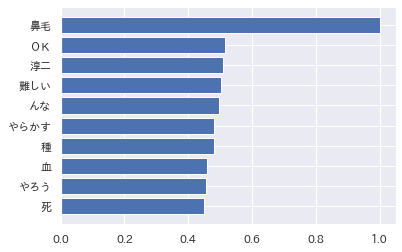

In [44]:
# display top N
top_N = 10
xs = np.arange(top_N, 0, -1)
plt.barh(xs, word_scores[:top_N])
plt.yticks(xs, word_rank[:top_N])
plt.show()